# Urgent
1. Reimplement the dataloader + saving of the .pt files => batch them such that the total number of nodes is < 5000 + include the initial graph representation (this is required for the encoder (we currently don't have it))

In [2]:
# !molecule_generation preprocess INPUT_DIR OUTPUT_DIR TRACE_DIR --generation-order=canonical

In [1]:
import os
os.chdir('/data/ongh0068/l1000/moler_reference')

In [2]:
import gzip
import pickle

with gzip.open('/data/ongh0068/l1000/trace_playground/metadata.pkl.gz', 'rb') as f:
     metadata= pickle.load(f)

2022-12-13 14:49:48.121501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import gzip
import pickle

with gzip.open('/data/ongh0068/l1000/trace_playground/train_0/train_0.pkl.gz', 'rb') as f:
     train= pickle.load(f)

# Misc TODOs

1. Add a motif embedding layer to the GNN => need to look into whether there are specific gnn layers for this
2. Dataset => validate if it is correct
3. Implement function for storing Data objects in the Pytorch geometric dataset
4. Implement all the helper function for the pytorch geometric dataset

# Dataset
The original dataset uses a function to randomly decide whether to include or exclude a particular partial graph from the batch. Instead of that, we try to simply save all Data objects a separate .pt files => at training time, we list all the file paths and then sample from the file paths uniformly 

- Downsides => will occupy more memory: potential optimisations (TODOs) would be to save as compressed file and only decompress at training time.
- Upside => less preprocessing time at training time


There will be 1 dataset object for each of the train/validation/test splits

In [41]:
%load_ext autoreload
%autoreload 2
from dataset import MolerDataset
MolerDataset._generate_self_loops(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([[0, 0],
       [1, 1]], dtype=int32)

In [42]:
import time

start = time.time()

dataset = MolerDataset(
    root = '/data/ongh0068', 
    raw_moler_trace_dataset_parent_folder = '/data/ongh0068/l1000/trace_playground',
    output_pyg_trace_dataset_parent_folder = '/data/ongh0068/l1000/pyg_output_playground',
    split = 'train',
)

end = time.time()
print(end - start)

Processing...


23.768383026123047


Done!


74 MB # using .pt

39 MB # using .pkl.gz

2.5 MB # if we group each generation step by molecule and save the entire list
       # as a pkl gz file

57.707035779953 # original time required for 100 molecules

43.484010457992554 # using threadpoolexecutor

33.62712216377258# using max workers processpool executor

24.90175437927246 # using 5 workers process pool

27.66532278060913 # using 10 workers


In [32]:
dataset[0]

0


MolerData(x=[4, 32], edge_index=[2, 10], original_graph_edge_type=[93], original_graph_node_categorical_features=[29], focus_node=[1], edge_type=[10], edge_features=[0, 3], correct_edge_choices=[0], num_correct_edge_choices=[1], stop_node_label=[1], valid_edge_choices=[0, 2], valid_edge_types=[0, 3], correct_edge_types=[0, 3], partial_node_categorical_features=[4], correct_attachment_point_choice=[0], correct_node_type_choices=[139], correct_first_node_type_choices=[139], sa_score=[1], clogp=[1], mol_weight=[1], qed=[1], bertz=[1], original_graph_edge_index=[2, 93], original_graph_x=[29, 32], valid_attachment_point_choices=[0])

In [62]:
from torch.utils.data import RandomSampler
from sampler import DuplicatedIndicesSamplerWrapper
import pandas as pd
processed_file_metadata = '/data/ongh0068/l1000/pyg_output_playground/train/processed_file_paths.csv'
molecule_gen_steps_lengths = pd.read_csv(processed_file_metadata)['molecule_gen_steps_length'].tolist()

random_sampler = RandomSampler(
    data_source = [i for i in range(len(dataset))]
)
sampler = DuplicatedIndicesSamplerWrapper(
    dataset = dataset,
    sampler = random_sampler,
    frequency_mapping = {idx: length for idx, length in enumerate(molecule_gen_steps_lengths)}
)


In [63]:
tmp = {idx: length for idx, length in enumerate(molecule_gen_steps_lengths)}

In [76]:
sum(molecule_gen_steps_lengths)

2384

In [64]:
indices = list(sampler)

In [65]:
from collections import Counter, OrderedDict

OrderedDict(sorted(Counter(indices).items()))== OrderedDict(sorted(tmp.items()))


True

In [70]:
# tmp

In [80]:
from torch_geometric.loader import DataLoader
from torch.utils.data import RandomSampler
from sampler import DuplicatedIndicesSamplerWrapper



loader = DataLoader(dataset, batch_size=16, shuffle=False, drop_last = False, sampler = sampler,  follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices'
])

In [79]:
149 * 16

2384

In [81]:
start = time.time()
for i, batch in enumerate(loader):
#     pprint_pyg_obj(batch)
#     print(i)
    pass
end = time.time()
print(end - start)

idx 6
8.27429723739624


In [105]:
from torch_geometric.data import Batch

Batch(tmp)

DataBatch(x=[5])

In [106]:
batch

MolerDataBatch(x=[78, 32], edge_index=[2, 246], original_graph_edge_type=[280], original_graph_node_categorical_features=[88], focus_node=[4], edge_type=[246], edge_features=[25, 3], correct_edge_choices=[25], correct_edge_choices_batch=[25], correct_edge_choices_ptr=[5], num_correct_edge_choices=[4], stop_node_label=[4], valid_edge_choices=[25, 2], valid_edge_choices_batch=[25], valid_edge_choices_ptr=[5], valid_edge_types=[2, 3], correct_edge_types=[2, 3], correct_edge_types_batch=[2], correct_edge_types_ptr=[5], partial_node_categorical_features=[78], correct_attachment_point_choice=[0], correct_attachment_point_choice_batch=[0], correct_attachment_point_choice_ptr=[5], correct_node_type_choices=[278], correct_node_type_choices_batch=[278], correct_node_type_choices_ptr=[5], correct_first_node_type_choices=[556], sa_score=[4], clogp=[4], mol_weight=[4], qed=[4], bertz=[4], original_graph_edge_index=[2, 280], original_graph_x=[88, 32], valid_attachment_point_choices=[0], valid_attach

# estimation

total number of molecules: 1273104 + 79568 + 238706

assuming we use gzip with pickle: 15913.78 * 39 /1000 = 620 GB


Time to iterate through the dataloader 12.01 seconds # using gzip and pickle with 100 molecules batch size 16
Time to iterate throught the dataloader 8.76393747329712 seconds # using .pt and torch load
Time to iterate through using ahdoc dataset?

#### using individual data objects and saving each using pkl and gzip, we still
#### end up with 620 gb => infeasible


Solution: 
1. Use adhoc dataset: `get` method will do everything that is being done in `process()`, and nothing is saved to disk => do this first and check the time taken to train per epoch

Currently, with .pt files,it takes 1.2 minutes per epoch for 100 molecules

2. batch it as much as possible then save it to disk during `process()` https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/batch.html

3. pack each molecule's generation steps into one pickle gz file (this idea can be extended to pack an arbitrary number of molecules into one pickle gz file to save more space), and then instantiate a randomsampler with num samples == to the total length of the dataset (need to get this information from the csv file which is saved during `process()`) 

For the sampler itself, we need to sample an index for each of the datashards that are in the folder, AND THEN after sampling, we need to duplicate the indices by the number of steps in that shard so that when we call the dataloader, at the end of the day, all training samples will be processed.

For example, if lets say we have 3 shards, and each shard has 4, 2, and 5 steps each. Then, in our custom sampler, we need to sample the indices first, eg 0, 2, 1, and then we need to use the mapping we have (that will tell us how much to duplicate each index by) to duplicate the indices. In this case, since we have 4 steps in shard 0, 2 steps in shard 1 and 5 steps in shard 2, we will need our final list to look like this \[0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1\]

In [62]:
def pprint_pyg_obj(batch):
    for key in vars(batch)['_store'].keys():
        if key.startswith('_'):
            continue
        print(f'{key}: {batch[key].shape}')
for batch in loader:
    pprint_pyg_obj(batch)
    break

x: torch.Size([193, 32])
edge_index: torch.Size([2, 563])
original_graph_edge_type: torch.Size([1488])
original_graph_node_categorical_features: torch.Size([464])
focus_node: torch.Size([16])
edge_type: torch.Size([563])
edge_features: torch.Size([86, 3])
correct_edge_choices: torch.Size([86])
correct_edge_choices_batch: torch.Size([86])
correct_edge_choices_ptr: torch.Size([17])
num_correct_edge_choices: torch.Size([16])
stop_node_label: torch.Size([16])
valid_edge_choices: torch.Size([86, 2])
valid_edge_choices_batch: torch.Size([86])
valid_edge_choices_ptr: torch.Size([17])
valid_edge_types: torch.Size([9, 3])
correct_edge_types: torch.Size([9, 3])
correct_edge_types_batch: torch.Size([9])
correct_edge_types_ptr: torch.Size([17])
partial_node_categorical_features: torch.Size([193])
correct_attachment_point_choice: torch.Size([0])
correct_attachment_point_choice_batch: torch.Size([0])
correct_attachment_point_choice_ptr: torch.Size([17])
correct_node_type_choices: torch.Size([1112])


In [63]:
batch.edge_index

tensor([[  1,   2,   0,  ..., 190, 191, 192],
        [  0,   1,   1,  ..., 190, 191, 192]], dtype=torch.int32)

In [4]:
import torch
import numpy as np

In [8]:
with gzip.open('/data/ongh0068/l1000/trace_playground/metadata.pkl.gz', 'rb') as f:
     metadata= pickle.load(f)

atom_type_featuriser = next(
    featuriser
    for featuriser in metadata["feature_extractors"]
    if featuriser.name == "AtomType"
)

node_type_index_to_string = atom_type_featuriser.index_to_atom_type_map.copy()
motif_vocabulary = metadata.get("motif_vocabulary")

if motif_vocabulary is not None:
    motif_to_node_type_index = get_motif_type_to_node_type_index_map(
        motif_vocabulary=motif_vocabulary,
        num_atom_types=len(node_type_index_to_string),
    )

    for motif, node_type in motif_to_node_type_index.items():
        node_type_index_to_string[node_type] = motif

In [9]:
def num_node_types():
    return len(node_type_index_to_string)

def node_type_to_index(node_type):
    return atom_type_featuriser.type_name_to_index(node_type)

def node_types_to_indices(node_types):
    node_type_to_index
    """Convert list of string representations into list of integer indices."""
    return [node_type_to_index(node_type) for node_type in node_types]

def node_types_to_multi_hot(node_types):
    """Convert between string representation to multi hot encoding of correct node types.

    Note: implemented here for backwards compatibility only.
    """
    num_node_types
    correct_indices = node_types_to_indices(node_types)
    multihot = np.zeros(shape=(num_node_types(),), dtype=np.float32)
    for idx in correct_indices:
        multihot[idx] = 1.0
    return multihot



    
train_sample = train[0]


graph_property_values = dict(train_sample.graph_property_values)

molecule_gen_steps = []
for gen_step in train_sample:
    gen_step_features = {}
    gen_step_features['x'] = gen_step.partial_node_features
    gen_step_features['focus_node'] = gen_step.focus_node
    
    # have an edge type attribute to tell apart each of the 3 bond types
    edge_indexes = []
    edge_types= []
    for i, adj_list in enumerate(gen_step.partial_adjacency_lists):
        if len(adj_list) != 0:
            edge_index = torch.tensor(adj_list).T
            edge_indexes += [edge_index]
            edge_types += [i]*len(adj_list)
    gen_step_features['edge_index'] = torch.cat(edge_indexes, 1)
    gen_step_features['edge_type'] = torch.tensor(edge_types)
    gen_step_features['correct_edge_choices'] = gen_step.correct_edge_choices
    
    num_correct_edge_choices = np.sum(gen_step.correct_edge_choices)
    gen_step_features['num_correct_edge_choices'] = num_correct_edge_choices
    gen_step_features['stop_node_label'] = int(num_correct_edge_choices == 0)
    gen_step_features['valid_edge_choices'] = gen_step.valid_edge_choices
    gen_step_features["correct_edge_types"] = gen_step.correct_edge_types
    gen_step_features["partial_node_categorical_features"] = gen_step.partial_node_categorical_features
    if gen_step.correct_attachment_point_choice is not None:
        gen_step_features["correct_attachment_point_choice"] = list(gen_step.valid_attachment_point_choices).index(gen_step.correct_attachment_point_choice)
    else:
        gen_step_features["correct_attachment_point_choice"] = []
    gen_step_features["valid_attachment_point_choices"] = gen_step.valid_attachment_point_choices
    
    # And finally, the correct node type choices. Here, we have an empty list of
    # correct choices for all steps where we didn't choose a node, so we skip that:
    if gen_step.correct_node_type_choices is not None:
        gen_step_features["correct_node_type_choices"] = node_types_to_multi_hot(gen_step.correct_node_type_choices)
    else:
        gen_step_features["correct_node_type_choices"] = []
    gen_step_features['correct_first_node_type_choices'] = node_types_to_multi_hot(train_sample.correct_first_node_type_choices)
    
    # Add graph_property_values
    gen_step_features = {**gen_step_features, **graph_property_values}
    
    molecule_gen_steps += [gen_step_features]
    
    
    
    
for i in range(len(molecule_gen_steps)):
    for k,v in molecule_gen_steps[i].items():
        molecule_gen_steps[i][k] = torch.tensor(molecule_gen_steps[i][k])
    

/tmp/ipykernel_2358557/307640579.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  molecule_gen_steps[i][k] = torch.tensor(molecule_gen_steps[i][k])


In [10]:
import torch
from torch_geometric.data import Data


# class MolerTraceData(Data):
#     def __cat_dim__(self, key, value, *args, **kwargs):
#         if key == 'foo':
#             return None
#     else:
#         return super().__cat_dim__(key, value, *args, **kwargs)


pyg_data = []
for step in molecule_gen_steps:
    pyg_data.append(Data(**step))
    

In [14]:
pyg_data[0]

Data(x=[4, 32], edge_index=[2, 6], focus_node=0, edge_type=[6], correct_edge_choices=[0], num_correct_edge_choices=0.0, stop_node_label=1, valid_edge_choices=[0, 2], correct_edge_types=[0, 3], partial_node_categorical_features=[4], correct_attachment_point_choice=[0], valid_attachment_point_choices=[0], correct_node_type_choices=[139], correct_first_node_type_choices=[139], sa_score=2.2193448543548584, clogp=3.466399908065796, mol_weight=407.0827331542969, qed=0.621309220790863, bertz=1218.9598388671875)

In [11]:
from torch_geometric.loader import DataLoader
loader = DataLoader(pyg_data, batch_size=16, shuffle=False, follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices'
])

In [12]:
batch.correct_edge_choices_ptr, batch.correct_node_type_choices_ptr

NameError: name 'batch' is not defined

In [216]:
batch.correct_edge_choices_batch

tensor([ 1,  1,  2,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,  8,
         9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15])

In [215]:
batch.correct_edge_choices.shape, batch.correct_node_type_choices.shape

(torch.Size([53]), torch.Size([1112]))

In [13]:
def pprint_pyg_obj(batch):
    for key in vars(batch)['_store'].keys():
        if key.startswith('_'):
            continue
        print(f'{key}: {batch[key].shape}')
for batch in loader:
    pprint_pyg_obj(batch)
    break

x: torch.Size([126, 32])
edge_index: torch.Size([2, 212])
focus_node: torch.Size([16])
edge_type: torch.Size([212])
correct_edge_choices: torch.Size([53])
correct_edge_choices_batch: torch.Size([53])
correct_edge_choices_ptr: torch.Size([17])
num_correct_edge_choices: torch.Size([16])
stop_node_label: torch.Size([16])
valid_edge_choices: torch.Size([53, 2])
valid_edge_choices_batch: torch.Size([53])
valid_edge_choices_ptr: torch.Size([17])
correct_edge_types: torch.Size([9, 3])
correct_edge_types_batch: torch.Size([9])
correct_edge_types_ptr: torch.Size([17])
partial_node_categorical_features: torch.Size([126])
correct_attachment_point_choice: torch.Size([0])
correct_attachment_point_choice_batch: torch.Size([0])
correct_attachment_point_choice_ptr: torch.Size([17])
valid_attachment_point_choices: torch.Size([0])
valid_attachment_point_choices_batch: torch.Size([0])
valid_attachment_point_choices_ptr: torch.Size([17])
correct_node_type_choices: torch.Size([1112])
correct_node_type_choi

In [238]:
from torch_geometric.nn import RGATConv

conv1 = RGATConv(in_channels = batch.x.shape[1], out_channels = batch.x.shape[1]//2, num_relations = 3)

In [239]:
conv1(batch.x, batch.edge_index.long(), batch.edge_type).shape # shape: [num_nodes, latent_feature_size]

torch.Size([126, 16])

In [211]:
batch.correct_node_type_choices, batch.correct_node_type_choices_batch

(tensor([0., 1., 0.,  ..., 0., 0., 0.]),
 tensor([ 0,  0,  0,  ..., 15, 15, 15]))

In [176]:
batch.correct_edge_types

tensor([[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]], dtype=torch.int32)

In [162]:
pyg_data[11].correct_edge_types

tensor([[0, 1, 0],
        [1, 0, 0]], dtype=torch.int32)

In [121]:
batch.ptr

tensor([  0,   4,   9,  14,  20,  26,  33,  40,  48,  56,  65,  74,  84,  94,
        104, 115, 126])

In [173]:
batch.correct_edge_types_batch

tensor([ 1,  3,  5,  7,  9, 11, 11, 12, 14])

In [128]:
np.repeat(np.arange(5, dtype=np.int32), 2).reshape(-1, 2)

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4]], dtype=int32)

# Issues to resolve

Here, for a batch size of 16, there are 4 nodes in the first sample in the batch and 126 nodes in total as seen from x. the `ptr` attribute tells us where each new graph starts in the batch.

TODO: 

Add the `is_conjugated` and the other bond properties to the preprocessing script as used in ogb https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py

Add self loops 

Add additional atom features from the ogb preprocessing files

split the l1000 dataset from the biaae github repo into train validation and test

currently .pt files take 16 kb each. This is too large, to consider using gzip with pickle OR consider batching and then saving the batch into a file by itself => then include in the processed csv the different molecules and the corresponding steps that appear in the zipped file







DONE: 

(DONE) Add graph property values

(DONE) There is something wrong with the multihot encoding: none of the node types are of value 1

(DONE: `follow_batch` was used instead of the things below)
1. edge_index: how do we tell which belongs to which graph? Does it matter?
2. focus node: NI
3. edge type: same as edge index, how to tell?
4. correct_edge_choices: need to put a -1 for those samples without any?
5. num_correct_edge_choices: NI, for each of the 16 samples => can be used to infer which graphs to use for training the decoder mlps
6. stop_node_label: NI
7. valid_edge_choices: need to put -1 for samples without any
8. correct_edge_types: need to put -1 for samples without any 
9. partial_node_categorical_features: NI
10. correct_attachment_point_choice: need to put -1 for samples without any
11. valid_attachment_point_choices: need to put -1 for samples without any

In [132]:
batch.correct_node_type_choices.unique()


tensor([0.])

In [130]:
batch.ptr[batch.ptr > 50] # use this kind of numpy like indexing to get 
# the values we want



tensor([ 56,  65,  74,  84,  94, 104, 115, 126])

In [52]:
metadata['motif_vocabulary']

{'C1=CC=CC=C1': 0,
 'C1CCNCC1': 1,
 'C1=CC=NC=C1': 2,
 'NC=O': 3,
 'C1CNCCN1': 4,
 'C1CCNC1': 5,
 'O=[N+][O-]': 6,
 'C1CC1': 7,
 'C1COCCN1': 8,
 'O=CO': 9,
 'N=CO': 10,
 'C1=CNN=C1': 11,
 'FC(F)F': 12,
 'CC=O': 13,
 'C1CCOCC1': 14,
 'C1=CC=C2C=CC=CC2=C1': 15,
 'COC=O': 16,
 'CCO': 17,
 'C=CC': 18,
 'C1=CSC=N1': 19,
 'C1=CSC=C1': 20,
 'C1=CON=C1': 21,
 'C1=CC=C2NC=CC2=C1': 22,
 'OC(F)F': 23,
 'O=CNO': 24,
 'CNC=O': 25,
 'CCNC(=O)OC': 26,
 'CCCO': 27,
 'CCC(N)=O': 28,
 'CCC(=O)O': 29,
 'CC(N)=O': 30,
 'CC(C)C': 31,
 'C1CCOC1': 32,
 'C1CCCCC1': 33,
 'C1=NC=C2CCCCC2=N1': 34,
 'C1=COC=C1': 35,
 'C1=CNC=C1': 36,
 'C1=CN=CN=C1': 37,
 'C1=CN=C2C=CC=CC2=C1': 38,
 'C1=CN2N=CC=C2N=C1': 39,
 'C1=CC=C2OC=CCC2=C1': 40,
 'C1=CC=C2N=CC=CC2=C1': 41,
 'C1=CC2=C(CCC2)S1': 42,
 'O=S=O': 43,
 'O=CNCCO': 44,
 'O=CNCCCCCNC=O': 45,
 'O=CNCCC(=O)O': 46,
 'O=CCCO': 47,
 'O=C(O)CS': 48,
 'N[SH](=O)=O': 49,
 'NNC=O': 50,
 'NCCO': 51,
 'NCCCC(N)=O': 52,
 'NC(N)=O': 53,
 'ClC(Cl)Cl': 54,
 'CSCCC(N)C(=O)O': 55,
 'CO

In [41]:
train_sample.correct_first_node_type_choices

['COC=O']

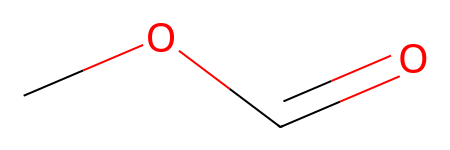

In [44]:
from rdkit import Chem
Chem.MolFromSmiles('COC=O')

In [15]:
import pandas as pd

In [22]:
df_l1000 = pd.read_csv('/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv', index_col = None)

['CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1',
 'CCCCC#Cc1nc(NC)c2ncn(C3OC(CO)C(O)C3O)c2n1',
 'CCN1c2ccccc2NC2N=C(OC)C(c3ccccc3)C21',
 'O=C1Cc2cc([S+](=O)(O)N3CCN(c4ccc(O)cc4)CC3)ccc2N1',
 'CCN(CC)CC1CCCCN1CC(=O)N1c2ccccc2C(=O)Nc2cccnc21',
 'OC(CCN1CCCCC1)(c1ccccc1)C1CC2C=CC1C2',
 'COc1ccc(C(CC(=O)N2CCCC(C)C2)c2c(O)cc(OC)cc2OC)cc1',
 'Cn1c(=O)c2c(ncn2CC(O)CO)n(C)c1=O',
 'OCc1cc(C(O)CNCCCCCCOCCCCc2ccccc2)ccc1O',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1',
 'CN(CCO)CC(O)Cn1cnc2c1c(=O)n(C)c(=O)n2C',
 'COc1ccc(C2C(C(=O)O)c3ccccc3C(=O)N2Cc2ccc(Cl)cc2)cc1',
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O',
 'COc1ccc(C2=Nn3c(nnc3-c3ccccc3C(F)(F)F)SC2)cc1OC1CCOC1',
 'CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc([N+](=O)[O-])c1',
 'CSCCC(N)C(=O)NC(CC(C)C)C(=O)NC(Cc1ccccc1)C(=O)O',
 'CC1CC(C)(C)N2C(=O)C3(Nc4ccccc4S3)c3cccc1c32',
 'CC(O)c1cc2c(s1)c1cnn(Cc3ccccc3F)c(=O)c1n2C',
 'COc1ccc(C#Cc2ccc3c(c2)C2C(CCN2S(=O)(=O)C2=NC(C)C=N2)C(CO)N3C)cc1',
 'CNC(C)C(=O)NC(C(=O)NC(C)C(=O)NNc1ccccc1)C(C)C',
 'COc1ccc(C(=O)

In [28]:
with open('/data/ongh0068/l1000/l1000_biaae/l1000_biaae.smiles', 'w') as f:
    for line in df_l1000.SMILES.unique().tolist():
        f.write(f"{line}\n")

In [29]:
dataset = MolerDataset(
    root = '/data/ongh0068', 
    raw_moler_trace_dataset_parent_folder = '/data/ongh0068/l1000/l1000_biaae/trace_dir',
    output_pyg_trace_dataset_parent_folder = '/data/ongh0068/l1000/l1000_biaae/pyg_output_dir',
    split = 'valid',
)

Processing...
/tmp/ipykernel_2358557/1771471215.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  molecule_gen_steps[i][k] = torch.tensor(molecule_gen_steps[i][k])


file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_0.pt
Processing 0, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_1.pt
Processing 0, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_2.pt
Processing 0, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_3.pt
Processing 0, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_4.pt
Processing 0, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_5.pt
Processing 0, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_6.pt
Processing 0, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_7.pt
Processing 0, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_0_step_8.pt
Processing 0, step 8
file_path /data/ong

Processing 3, step 28
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_3_step_29.pt
Processing 3, step 29
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_3_step_30.pt
Processing 3, step 30
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_3_step_31.pt
Processing 3, step 31
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_0.pt
Processing 4, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_1.pt
Processing 4, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_2.pt
Processing 4, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_3.pt
Processing 4, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_4.pt
Processing 4, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_4_step_5.pt
Processing 4

Processing 7, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_13.pt
Processing 7, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_14.pt
Processing 7, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_15.pt
Processing 7, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_16.pt
Processing 7, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_17.pt
Processing 7, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_7_step_18.pt
Processing 7, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_8_step_0.pt
Processing 8, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_8_step_1.pt
Processing 8, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_8_step_2.pt
Proces

Processing 11, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_11_step_12.pt
Processing 11, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_11_step_13.pt
Processing 11, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_11_step_14.pt
Processing 11, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_11_step_15.pt
Processing 11, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_11_step_16.pt
Processing 11, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_12_step_0.pt
Processing 12, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_12_step_1.pt
Processing 12, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_12_step_2.pt
Processing 12, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_12_

Processing 15, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_12.pt
Processing 15, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_13.pt
Processing 15, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_14.pt
Processing 15, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_15.pt
Processing 15, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_16.pt
Processing 15, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_15_step_17.pt
Processing 15, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_16_step_0.pt
Processing 16, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_16_step_1.pt
Processing 16, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_1

Processing 19, step 20
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_19_step_21.pt
Processing 19, step 21
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_0.pt
Processing 20, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_1.pt
Processing 20, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_2.pt
Processing 20, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_3.pt
Processing 20, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_4.pt
Processing 20, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_5.pt
Processing 20, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_6.pt
Processing 20, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_20_step_7.p

Processing 23, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_23_step_17.pt
Processing 23, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_23_step_18.pt
Processing 23, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_23_step_19.pt
Processing 23, step 19
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_23_step_20.pt
Processing 23, step 20
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_23_step_21.pt
Processing 23, step 21
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_24_step_0.pt
Processing 24, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_24_step_1.pt
Processing 24, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_24_step_2.pt
Processing 24, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_24_

Processing 28, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_10.pt
Processing 28, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_11.pt
Processing 28, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_12.pt
Processing 28, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_13.pt
Processing 28, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_14.pt
Processing 28, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_15.pt
Processing 28, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_16.pt
Processing 28, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_28_step_17.pt
Processing 28, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mo

Processing 33, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_1.pt
Processing 33, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_2.pt
Processing 33, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_3.pt
Processing 33, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_4.pt
Processing 33, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_5.pt
Processing 33, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_6.pt
Processing 33, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_7.pt
Processing 33, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_8.pt
Processing 33, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_33_step_9.pt
P

Processing 37, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_8.pt
Processing 37, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_9.pt
Processing 37, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_10.pt
Processing 37, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_11.pt
Processing 37, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_12.pt
Processing 37, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_13.pt
Processing 37, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_14.pt
Processing 37, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37_step_15.pt
Processing 37, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_37

Processing 41, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_41_step_16.pt
Processing 41, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_41_step_17.pt
Processing 41, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_41_step_18.pt
Processing 41, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step_0.pt
Processing 42, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step_1.pt
Processing 42, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step_2.pt
Processing 42, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step_3.pt
Processing 42, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step_4.pt
Processing 42, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_42_step

Processing 43, step 48
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_49.pt
Processing 43, step 49
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_50.pt
Processing 43, step 50
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_51.pt
Processing 43, step 51
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_52.pt
Processing 43, step 52
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_53.pt
Processing 43, step 53
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_54.pt
Processing 43, step 54
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_55.pt
Processing 43, step 55
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_43_step_56.pt
Processing 43, step 56
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_m

Processing 47, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_47_step_16.pt
Processing 47, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_47_step_17.pt
Processing 47, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_47_step_18.pt
Processing 47, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_47_step_19.pt
Processing 47, step 19
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_47_step_20.pt
Processing 47, step 20
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_48_step_0.pt
Processing 48, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_48_step_1.pt
Processing 48, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_48_step_2.pt
Processing 48, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_48_

Processing 52, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_10.pt
Processing 52, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_11.pt
Processing 52, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_12.pt
Processing 52, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_13.pt
Processing 52, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_14.pt
Processing 52, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_15.pt
Processing 52, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_16.pt
Processing 52, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_52_step_17.pt
Processing 52, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mo

Processing 56, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_8.pt
Processing 56, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_9.pt
Processing 56, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_10.pt
Processing 56, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_11.pt
Processing 56, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_12.pt
Processing 56, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_13.pt
Processing 56, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_14.pt
Processing 56, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56_step_15.pt
Processing 56, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_56

Processing 59, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_3.pt
Processing 59, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_4.pt
Processing 59, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_5.pt
Processing 59, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_6.pt
Processing 59, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_7.pt
Processing 59, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_8.pt
Processing 59, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_9.pt
Processing 59, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_10.pt
Processing 59, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_59_step_11.p

Processing 62, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_19.pt
Processing 62, step 19
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_20.pt
Processing 62, step 20
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_21.pt
Processing 62, step 21
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_22.pt
Processing 62, step 22
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_23.pt
Processing 62, step 23
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_24.pt
Processing 62, step 24
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_25.pt
Processing 62, step 25
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_62_step_26.pt
Processing 62, step 26
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_m

Processing 67, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_13.pt
Processing 67, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_14.pt
Processing 67, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_15.pt
Processing 67, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_16.pt
Processing 67, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_17.pt
Processing 67, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_18.pt
Processing 67, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_19.pt
Processing 67, step 19
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_67_step_20.pt
Processing 67, step 20
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_m

Processing 71, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_1.pt
Processing 71, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_2.pt
Processing 71, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_3.pt
Processing 71, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_4.pt
Processing 71, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_5.pt
Processing 71, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_6.pt
Processing 71, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_7.pt
Processing 71, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_8.pt
Processing 71, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_71_step_9.pt
P

Processing 75, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_0.pt
Processing 76, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_1.pt
Processing 76, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_2.pt
Processing 76, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_3.pt
Processing 76, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_4.pt
Processing 76, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_5.pt
Processing 76, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_6.pt
Processing 76, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_7.pt
Processing 76, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_76_step_8.pt


Processing 79, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_5.pt
Processing 79, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_6.pt
Processing 79, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_7.pt
Processing 79, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_8.pt
Processing 79, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_9.pt
Processing 79, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_10.pt
Processing 79, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_11.pt
Processing 79, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_12.pt
Processing 79, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_79_step_

Processing 82, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_82_step_14.pt
Processing 82, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_82_step_15.pt
Processing 82, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_82_step_16.pt
Processing 82, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_82_step_17.pt
Processing 82, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_82_step_18.pt
Processing 82, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_83_step_0.pt
Processing 83, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_83_step_1.pt
Processing 83, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_83_step_2.pt
Processing 83, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_83_

Processing 86, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_86_step_15.pt
Processing 86, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_0.pt
Processing 87, step 0
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_1.pt
Processing 87, step 1
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_2.pt
Processing 87, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_3.pt
Processing 87, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_4.pt
Processing 87, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_5.pt
Processing 87, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_6.pt
Processing 87, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_87_step_7.p

Processing 90, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_11.pt
Processing 90, step 11
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_12.pt
Processing 90, step 12
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_13.pt
Processing 90, step 13
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_14.pt
Processing 90, step 14
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_15.pt
Processing 90, step 15
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_16.pt
Processing 90, step 16
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_17.pt
Processing 90, step 17
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_90_step_18.pt
Processing 90, step 18
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_m

Processing 94, step 25
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_26.pt
Processing 94, step 26
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_27.pt
Processing 94, step 27
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_28.pt
Processing 94, step 28
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_29.pt
Processing 94, step 29
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_30.pt
Processing 94, step 30
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_31.pt
Processing 94, step 31
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_32.pt
Processing 94, step 32
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_94_step_33.pt
Processing 94, step 33
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_m

Processing 98, step 2
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_3.pt
Processing 98, step 3
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_4.pt
Processing 98, step 4
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_5.pt
Processing 98, step 5
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_6.pt
Processing 98, step 6
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_7.pt
Processing 98, step 7
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_8.pt
Processing 98, step 8
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_9.pt
Processing 98, step 9
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_10.pt
Processing 98, step 10
file_path /data/ongh0068/l1000/l1000_biaae/pyg_output_dir/valid/valid_0_mol_98_step_11.p

Done!


In [30]:
dataset

MolerDataset()